In [91]:
import icarusplot
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [92]:
WD = '/Users/jskim/Documents/Neutrino/ICARUS/GUNDAM-1.9.X/work/run_configs/250723_MultiplicativeTemplate/TemplateSumRegCov_LCurve'

In [93]:
VariableXName = 'MuonCos'
VariableYName = 'MuonProtonCos'

# VariableXName = 'deltaPT'
# VariableYName = 'deltaalphaT'

In [94]:
Log10Strenghts = []
flist = glob.glob(f'{WD}/outputs/output_Fitter_{VariableXName}_and_{VariableYName}_Log10Strength*.root')
for fpath in flist:
    fname = fpath.split('/')[-1]
    this_strength = fname.replace(f'output_Fitter_{VariableXName}_and_{VariableYName}_Log10Strength','').replace('.root','')
    Log10Strenghts.append( float(this_strength) )

Log10Strenghts.sort()
Log10Strenghts = np.array(Log10Strenghts)

# Strenght_min = 0.1
# Strenght_max = 4.9
# Strenght_d = 0.1

# Strenghts = []
# tmp_Strenght = Strenght_min
# while tmp_Strenght<=Strenght_max:
#   Strenghts.append(tmp_Strenght)
#   tmp_Strenght += Strenght_d

# Strenghts = [0.1]

In [102]:
Log10Strenghts = Log10Strenghts[(np.pow(10., Log10Strenghts)<0.5) & (np.pow(10., Log10Strenghts)>0.05)]

In [103]:
Lambdas = []
LLHStats = []
LLHRegs = []
LLHNormRegs = []

for Log10Strenght in Log10Strenghts:

    Strenght = pow(10., Log10Strenght)

    RegStrName = f'{Log10Strenght:1.2f}'
    this_FitterOutputFilePath = f'{WD}/outputs/output_Fitter_{VariableXName}_and_{VariableYName}_Log10Strength{RegStrName}.root'

    with uproot.open(this_FitterOutputFilePath) as f:

        if 'FitterEngine/postFit/bestFitStats' not in f:
            print(f'No bestfit stat in {RegStrName}')
            continue

        df_bfstat = f['FitterEngine/postFit/bestFitStats'].arrays(library='pd').iloc[0]
        df_hesse = f['FitterEngine/postFit/hesseStats'].arrays(library='pd').iloc[0]
        
        HesseSuccess = df_hesse['covStatusCode']==3
        if not HesseSuccess:
            print(f'{RegStrName} failed')
            continue

    LLH_Stat = df_bfstat['statLikelihoodAtBestFit']
    LLH_Reg_VarX = df_bfstat[f'Template_Parameter_{VariableXName}']['llhPenalty']
    LLH_Reg_VarY = df_bfstat[f'Template_Parameter_{VariableYName}']['llhPenalty']
    LLH_Reg = LLH_Reg_VarX+LLH_Reg_VarY
    LLH_NormReg = LLH_Reg/Strenght

    Lambdas.append(Strenght)
    LLHStats.append(LLH_Stat)
    LLHRegs.append(LLH_Reg)
    LLHNormRegs.append(LLH_NormReg)
    
Lambdas = np.array(Lambdas)
LLHStats = np.array(LLHStats)
LLHRegs = np.array(LLHRegs)
LLHNormRegs = np.array(LLHNormRegs)


# print(Lambdas)
# print(LLHStats)
# print(LLHRegs)


0.15047578431027392
0.4677351412871982


Text(0, 0.5, 'Curvature')

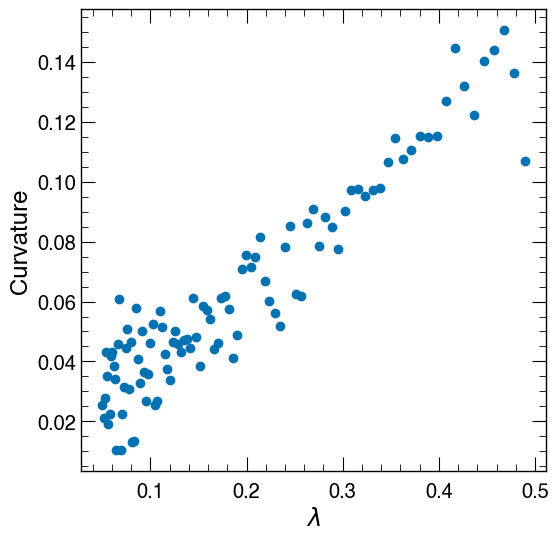

In [104]:
dx = np.gradient(LLHStats)
dy = np.gradient(LLHNormRegs)

ddx = np.gradient(dx)
ddy = np.gradient(dy)

# Compute curvature
curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5

index_Max_Curvature = np.argmax(curvature)

print(curvature[index_Max_Curvature])
print(Lambdas[index_Max_Curvature])

fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    Lambdas,
    curvature,
    marker='o',
    linestyle='',
)

ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Curvature')

Text(0.5, 0, '$\\lambda$')

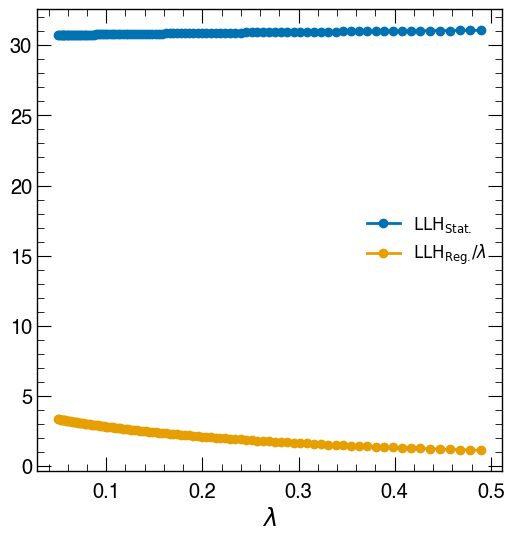

In [105]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    Lambdas,
    LLHStats,
    marker='o',
    # linestyle='',
    label=r'$\mathrm{LLH}_{\text{Stat.}}$'
)

ax.plot(
    Lambdas,
    LLHNormRegs,
    marker='o',
    # linestyle='',
    label=r'$\mathrm{LLH}_{\text{Reg.}}/\lambda$'
)

# ax.set_xlim(0, 1.0)
# ax.set_ylim(0., 1.5)

# ax.set_ylim(1E-2, 50)
# ax.set_yscale('log')
ax.legend()

ax.set_xlabel(r'$\lambda$')

# fig.savefig(f'{WD}/LCurve.pdf', bbox_inches='tight')

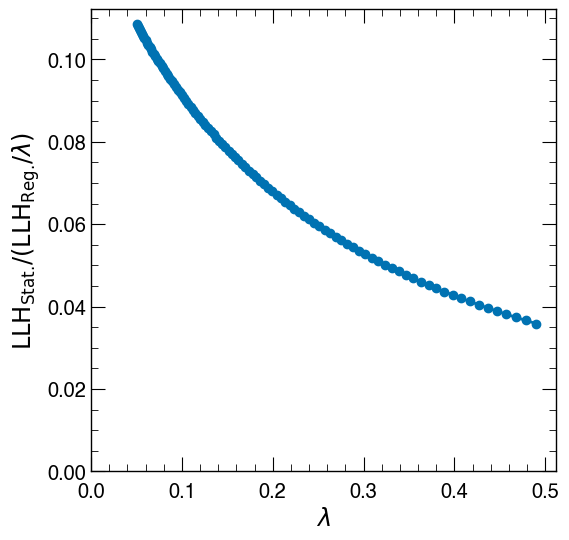

In [106]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    Lambdas,
    LLHNormRegs/LLHStats,
    marker='o',
    # linestyle='',
    label=r'$\mathrm{LLH}_{\text{Stat.}}$'
)

ax.set_xlim(0)
ax.set_ylim(0)

ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\mathrm{LLH}_{\text{Stat.}}/(\mathrm{LLH}_{\text{Reg.}}/\lambda)$')

fig.savefig(f'{WD}/LCurve_Ratio.pdf', bbox_inches='tight')

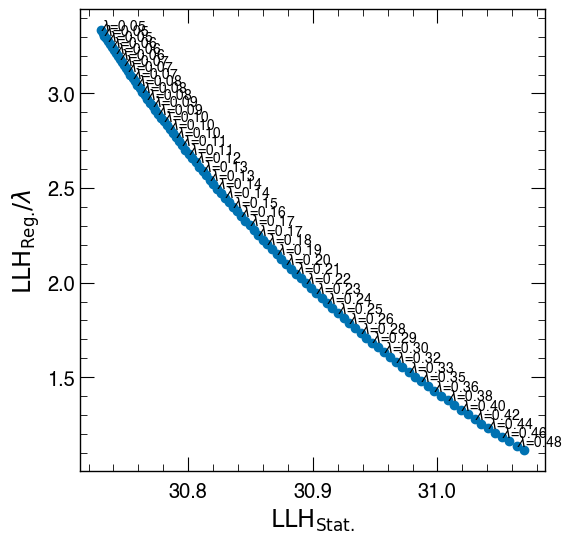

In [107]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    LLHStats,
    LLHNormRegs,
    marker='o',
    linestyle='',
)

# ax.set_xlim(30.0, 33.0)
# ax.set_ylim(0., 3.0)

for i, Lambda in enumerate(Lambdas):
    if i % 2 == 0:
        ax.annotate(r'$\lambda$='+'%1.2f'%(Lambda), (LLHStats[i], LLHNormRegs[i]))


ax.set_xlabel(r'$\mathrm{LLH}_{\text{Stat.}}$')

ax.set_ylabel(r'$\mathrm{LLH}_{\text{Reg.}}/\lambda$')

fig.savefig(f'{WD}/LCurve.pdf', bbox_inches='tight')

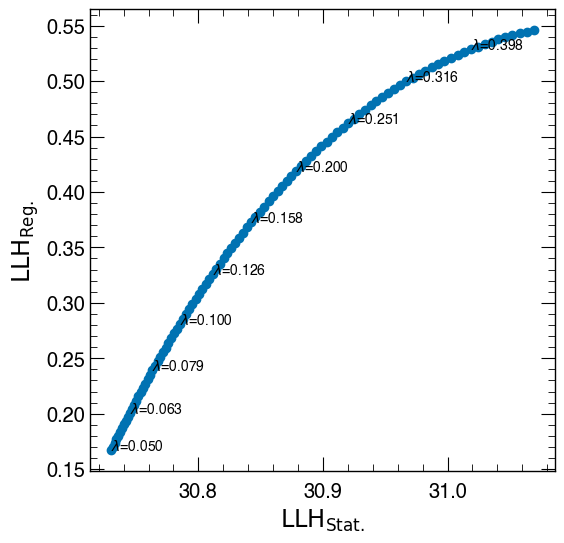

In [108]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    LLHStats,
    LLHRegs,
    marker='o',
    linestyle='',
)

ax.set_xlabel(r'$\mathrm{LLH}_{\text{Stat.}}$')
ax.set_ylabel(r'$\mathrm{LLH}_{\text{Reg.}}$')

for i, Lambda in enumerate(Lambdas):
    if i % 10 == 0:
        ax.annotate(r'$\lambda$='+'%1.3f'%(Lambda), (LLHStats[i], LLHRegs[i]))

fig.savefig(f'{WD}/LCurve_LLHReg.pdf', bbox_inches='tight')